In [73]:
import numpy as np
data = np.load('results/save-09.28.2025_21.33.14/evaluations.npz')
print(data['timesteps'].shape)
print(data['results'].shape)

(2995,)
(2995, 5)


# RL Training Evaluation Visualization

This notebook visualizes training evaluation logs saved in an `evaluations.npz` file produced by `EvalCallback` (or custom callbacks). It helps answer:

- How did mean episodic return evolve? (and variance)
- Did episode length shrink (faster success) or explode (instability)?
- Is return-per-step improving (efficiency metric)?
- What is an approximate success rate (threshold-based) and how sensitive is it?
- Where is the best (highest mean return) checkpoint among evaluations?

> Note: A lower late-stage total episodic return can still mean a **better** policy if episodes terminate earlier due to fast success. Thus we plot both cumulative return and efficiency metrics.

Sections:
1. Config & data loading
2. Metric computation
3. Return curve (+ smoothing and best point)
4. Episode length & efficiency
5. Approximate success rate (threshold variants)
6. Data table & optional export

In [74]:
# 1. Config & data loading
import os, json, math, numpy as np
from pathlib import Path

# Path to evaluations.npz (adjust if needed)
EVAL_PATH = Path('results')
# Auto-pick latest save-* folder containing evaluations.npz if not specified
candidates = sorted(EVAL_PATH.glob('save-*/evaluations.npz'))
if len(candidates) == 0:
    raise FileNotFoundError('No evaluations.npz found under results/. Train first.')
LATEST = candidates[-1]
print(f'Using evaluation file: {LATEST}')

data = np.load(LATEST, allow_pickle=True)
print('Keys in file:', list(data.keys()))

timesteps = data['timesteps']
results = data['results']  # shape: (N, n_eval_episodes)
if 'ep_lengths' in data:
    ep_lengths = data['ep_lengths']
else:
    ep_lengths = None

print(f'Num eval rounds: {len(timesteps)}  | Episodes per eval: {results.shape[1]}')
print('First 5 timesteps:', timesteps[:5])
print('Last 5 timesteps:', timesteps[-5:])

Using evaluation file: results/save-09.28.2025_21.33.14/evaluations.npz
Keys in file: ['timesteps', 'results', 'ep_lengths']
Num eval rounds: 2995  | Episodes per eval: 5
First 5 timesteps: [1000 2000 3000 4000 5000]
Last 5 timesteps: [2991000 2992000 2993000 2994000 2995000]


In [75]:
# 2. Metric computation
import pandas as pd

mean_return = results.mean(axis=1)
std_return = results.std(axis=1)

if ep_lengths is not None:
    mean_ep_len = ep_lengths.mean(axis=1)
    std_ep_len = ep_lengths.std(axis=1)
    return_per_step = mean_return / mean_ep_len
else:
    mean_ep_len = np.full_like(mean_return, np.nan)
    std_ep_len = np.full_like(mean_return, np.nan)
    return_per_step = np.full_like(mean_return, np.nan)

# Global threshold success heuristic (percentile over all episodes)
flat_returns = results.flatten()
percentile_threshold = 70
success_threshold_global = np.percentile(flat_returns, percentile_threshold)
success_rate_global = (results > success_threshold_global).mean(axis=1)

# Adaptive (per-eval) threshold (not comparable across evals, but shows internal skew)
success_threshold_adaptive = np.percentile(results, percentile_threshold, axis=1, keepdims=True)
success_rate_adaptive = (results > success_threshold_adaptive).mean(axis=1)

# Best mean_return index
best_idx = mean_return.argmax()
# Also best efficiency index
best_eff_idx = (~np.isnan(return_per_step) * (return_per_step == np.nanmax(return_per_step))).argmax()

summary = {
    'eval_rounds': len(mean_return),
    'episodes_per_eval': results.shape[1],
    'best_mean_return': float(mean_return[best_idx]),
    'best_mean_return_timestep': int(timesteps[best_idx]),
    'best_efficiency_return_per_step': float(return_per_step[best_eff_idx]) if not np.isnan(return_per_step[best_eff_idx]) else None,
    'best_efficiency_timestep': int(timesteps[best_eff_idx]) if not np.isnan(return_per_step[best_eff_idx]) else None,
    'global_success_threshold': float(success_threshold_global)
}
print(json.dumps(summary, indent=2))

{
  "eval_rounds": 2995,
  "episodes_per_eval": 5,
  "best_mean_return": 382.0491051673889,
  "best_mean_return_timestep": 2985000,
  "best_efficiency_return_per_step": 1.875114255146573,
  "best_efficiency_timestep": 2669000,
  "global_success_threshold": 180.4668407678604
}


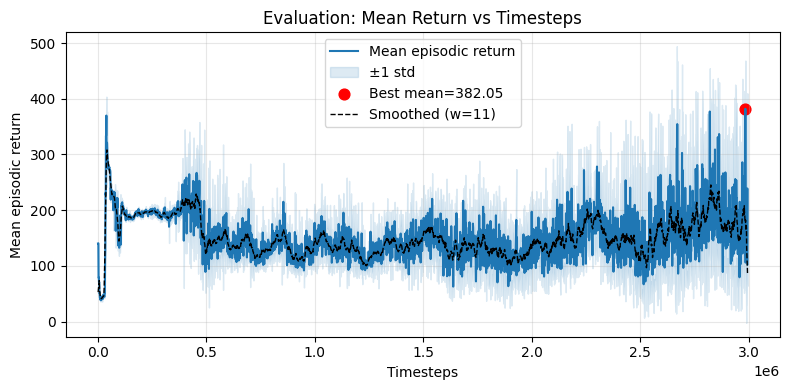

In [76]:
# 3. Plot: mean return curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(timesteps, mean_return, label='Mean episodic return', color='tab:blue')
plt.fill_between(timesteps, mean_return-std_return, mean_return+std_return, color='tab:blue', alpha=0.15, label='±1 std')
plt.scatter([timesteps[best_idx]],[mean_return[best_idx]],color='red',s=60,label=f'Best mean={mean_return[best_idx]:.2f}')

# Optional smoothing (simple moving average)
if len(mean_return) > 5:
    window = min(11, len(mean_return)//2*2+1)  # odd window
    smooth = np.convolve(mean_return, np.ones(window)/window, mode='same')
    plt.plot(timesteps, smooth, color='black', linestyle='--', linewidth=1, label=f'Smoothed (w={window})')

plt.xlabel('Timesteps')
plt.ylabel('Mean episodic return')
plt.title('Evaluation: Mean Return vs Timesteps')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

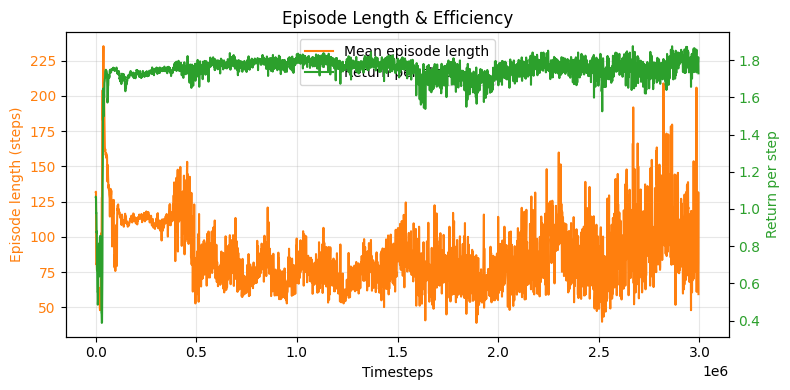

In [77]:
# 4. Plot: episode length & efficiency
if ep_lengths is not None:
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(timesteps, mean_ep_len, color='tab:orange', label='Mean episode length')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Episode length (steps)', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(timesteps, return_per_step, color='tab:green', label='Return per step')
    ax2.set_ylabel('Return per step', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Combine legends
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')
    plt.title('Episode Length & Efficiency')
    plt.tight_layout()
    plt.show()
else:
    print('ep_lengths not available: cannot compute efficiency plot.')

In [78]:
# 6. Tabular summary & optional CSV export
import pandas as pd

rows = []
for i, t in enumerate(timesteps):
    row = {
        'timestep': int(t),
        'mean_return': float(mean_return[i]),
        'std_return': float(std_return[i]),
    }
    if ep_lengths is not None:
        row['mean_ep_len'] = float(mean_ep_len[i])
        row['return_per_step'] = float(return_per_step[i])
    if 'global_success_rate_history' in globals():
        row['global_success_rate'] = float(global_success_rate_history[i])
        row['adaptive_success_rate'] = float(adaptive_success_rate_history[i])
    rows.append(row)

df = pd.DataFrame(rows)
display(df.head())
print(f'Total evaluation points: {len(df)}')

latest_eval_path = os.path.dirname('results/save-09.28.2025_21.33.14')

EXPORT_CSV = True  # set True to write file
if EXPORT_CSV:
    out_path = latest_eval_path + '/evaluation_metrics.csv'
    df.to_csv(out_path, index=False)
    print('Saved metrics to', out_path)

,timestep,mean_return,std_return,mean_ep_len,return_per_step
0,1000,140.349778,0.346542,131.8,1.064869
1,2000,140.518667,0.000000,132.0,1.064535
2,3000,78.770006,1.093415,80.6,0.977295
3,4000,79.298996,0.000224,81.0,0.979000
4,5000,70.166615,2.119307,80.4,0.872719


Total evaluation points: 2995
Saved metrics to results/evaluation_metrics.csv


### Next Steps (Optional)

1. Integrate the custom composite evaluation callback into `learn.py` to log success & efficiency during training.
2. Add a terminal bonus or time penalty to better align episodic return with success speed.
3. Persist best-efficiency model separately (e.g., `best_efficiency_model.zip`).
4. Extend reward shaping to discourage oscillations (e.g., small penalty on body angular rates or thrust variance).
5. Track additional metrics: max altitude overshoot, settling time, success latency (first time within success radius).

下面分三部分回答：  
1) 为什么在那个时刻（即使以后曲线下降）会记录“最优策略”  
2) 评价标准究竟是什么（源码逻辑 + 数学形式）  
3) 用具体数值举两个对比例子帮助你直观理解  

---

## 1. 为什么“那一刻”被记录为最优？

`EvalCallback` 的逻辑是：每隔 `eval_freq` 步做一次评估，跑 `n_eval_episodes` 条完整 episode，计算它们的“回合总奖励”（每条 episode 的所有 step 奖励累加），然后取平均：

\[
\text{mean\_return}_k = \frac{1}{n_{\text{eval}}}\sum_{j=1}^{n_{\text{eval}}} \Big(\sum_{t=0}^{T_{k,j}-1} r_{k,j,t}\Big)
\]

如果这一轮的 `mean_return_k` 严格大于历史保存的 `best_mean_return`，就：
- 覆盖保存 `best_model.zip`
- 如果你还设置了 `StopTrainingOnRewardThreshold` 并且 `mean_return_k >= 阈值`，触发提前停止

“为什么后面即使训练继续，best 没更新？”——因为后面每一轮的评估平均回报都没有再超过当时的 `best_mean_return`。**最佳**指的是“迄今为止评估结果中的最大值”，不是“最近的值”。

---

## 2. 评价标准是什么？

### 奖励源
你的单步奖励（HoverAviary）：
\[
r_t = \max\big(0,\ 2 - \|p_{\text{target}} - p_{\text{current}}\|^4\big)
\]

### 回合总奖励（episodic return）
\[
R^{(j)} = \sum_{t=0}^{T^{(j)}-1} r_t
\]

### 评估平均回报（评估轮 k）
\[
\overline{R}_k = \frac{1}{n_{\text{eval}}} \sum_{j=1}^{n_{\text{eval}}} R^{(j)}
\]

### 最优判定
\[
\text{若 } \overline{R}_k > \text{best\_so\_far} \text{，则保存当前策略为 best}
\]

它 **不关心**：
- 是否更“快”完成
- 是否更“稳定”
- 是否“平均每步奖励”更高  
——只看“同一次评估那批完整回合的平均总奖励数值是否更大”。

---

## 3. 举例：为什么有时“更快更好”反而不是 best，反而中期策略被认定 best

### 场景设定
- 目标：到达半径 0.1 内立即终止
- 每步最多奖励接近 2（靠得很近）
- 中等距离（比如距离 0.4～0.6）时，每步奖励很小（接近 0）
- `n_eval_episodes = 5`

---

### 例子 A：中期策略（被记录为 best）

| Episode | 步数 T | 行为描述 | 典型奖励序列概念 | 回合总奖励 R |
|---------|-------|----------|------------------|--------------|
| 1 | 220 | 慢慢靠近但没终止 | 前150步几乎 0，后70步逐渐 0.2~1.2 | 40 |
| 2 | 230 | 类似 | … | 42 |
| 3 | 210 | 类似 | … | 38 |
| 4 | 225 | 类似 | … | 41 |
| 5 | 215 | 类似 | … | 39 |

平均：
\[
\overline{R}_{mid} = \frac{40+42+38+41+39}{5} = 40
\]

保存为当前 best： `best_mean_return = 40`

---

### 例子 B：后期更高效策略（但没刷新 best）

| Episode | 步数 T | 行为描述 | 奖励分布 | 回合总奖励 R |
|---------|-------|----------|---------|--------------|
| 1 | 28 | 20步接近中等距离，后8步迅速进入目标 | 后 8 步接近 1.0~1.9 | 12 |
| 2 | 26 | 类似 |  | 11.5 |
| 3 | 30 | 有些路径小抖动 |  | 13 |
| 4 | 24 | 很快到达 |  | 12 |
| 5 | 27 | 正常 |  | 11.8 |

平均：
\[
\overline{R}_{late} \approx 12.06 < 40
\]

虽然策略从任务角度明显“更好”（更快、更准），但是**评估指标只看回合总奖励总和**，所以不会刷新 best。

---

### 例子 C：真正刷新 best 的后期情况（罕见）

假设你后来加了“终端奖励 +10” ：

| Episode | 步数 T | 奖励结构 | 回合总奖励 |
|---------|-------|----------|------------|
| 1 | 28 | 路径奖励 ~12 + 终端奖励 10 | 22 |
| 2 | 26 | 11 + 10 | 21 |
| 3 | 30 | 13 + 10 | 23 |
| 4 | 24 | 10 + 10 | 20 |
| 5 | 25 | 11 + 10 | 21 |

平均：
\[
\overline{R}_{late\_bonus} = (22+21+23+20+21)/5 = 21.4
\]
仍然没超过 40（之前的“磨蹭型”策略），**仍不刷新**。  
只有当每步奖励权重或终端奖励值足够大（使得“快成功”的回合有更高总和）才可能刷新。

---

## 4. 你的“为什么那个时候记录最优”一句话总结

因为那一次评估得到的“平均回合累计奖励”是迄今为止最大的，即使它代表的是一种“低效但慢慢刷奖励”的策略；后面策略虽然更快完成任务，但在当前奖励设计下，“总和型指标”没有变大，所以不再覆盖。

---

## 5. 如果你希望“更快更好”= 更高指标，有哪些可选优化？

| 目标 | 做法 | 影响 |
|------|------|------|
| 奖励鼓励速度 | 增加终端奖励：`if success: reward += C` | 短回合也能拿大总分 |
| 惩罚拖延 | 每步加小惩罚：`reward -= 0.01` | 逼迫缩短 T |
| 稳定 per-step 指标 | 改 eval 判据为 `mean_return / mean_ep_len` | 注重效率 |
| 加成功率统计 | 自定义 Callback | 减少总和偏见 |
| 多指标保存 | 保存 top-K (总回报、效率) | 更全面对比 |

---

## 6. 你可以马上尝试的一段“效率+成功率”分析代码

把下面的代码加到你的 eval.ipynb 里新一个单元：



In [79]:
import numpy as np
import pandas as pd

data = np.load('results/save-09.28.2025_21.33.14/evaluations.npz')
timesteps = data['timesteps']
results = data['results']                 # shape: (N, n_eval_episodes)
ep_mean = results.mean(axis=1)
ep_std = results.std(axis=1)

if 'ep_lengths' in data:
    ep_lengths = data['ep_lengths']
    mean_len = ep_lengths.mean(axis=1)
    per_step_eff = ep_mean / mean_len
else:
    mean_len = None
    per_step_eff = None

df = pd.DataFrame({
    'timesteps': timesteps,
    'mean_return': ep_mean,
    'std_return': ep_std,
    'mean_ep_len': mean_len if mean_len is not None else np.nan,
    'return_per_step': per_step_eff if per_step_eff is not None else np.nan
})

print(df.tail(10))
print("\nBest mean_return at timestep:{}, value: {:.2f}".format(
      df.iloc[df['mean_return'].idxmax()]['timesteps'],
      df['mean_return'].max()
))

if per_step_eff is not None:
    print("Best efficiency (return_per_step) at timestep:{}, value: {:.4f}".format(
          df.iloc[df['return_per_step'].idxmax()]['timesteps'],
          df['return_per_step'].max()
    ))
    
success_threshold = np.percentile(results, 70)  # 或手动设，如 30
success_rate = (results > success_threshold).mean(axis=1)
df['success_rate'] = success_rate

      timesteps  mean_return  std_return  mean_ep_len  return_per_step
2985    2986000   105.786073   28.262367         61.0         1.734198
2986    2987000   135.278155   65.085377         75.8         1.784672
2987    2988000   114.592753   64.416968         64.8         1.768407
2988    2989000   154.157659  156.567026         85.0         1.813620
2989    2990000   152.683022   67.612794         84.8         1.800507
2990    2991000   183.741295  152.599498        101.6         1.808477
2991    2992000   118.853611   34.784099         67.2         1.768655
2992    2993000   147.125392   49.730338         82.0         1.794212
2993    2994000   238.962546  170.878092        131.6         1.815825
2994    2995000   102.712245   38.430060         59.4         1.729162

Best mean_return at timestep:2985000.0, value: 382.05
Best efficiency (return_per_step) at timestep:2669000.0, value: 1.8751




---

## 7. 最后一句话总结

“那次被记录为最优”只是因为它的“平均回合总奖励数值”最大；不是因为之后策略变差，而是**指标不再偏向‘快成功’**。如果你希望指标与“真实任务质量”（快、准、稳）对齐，就需要调整奖励或引入新的评估标准。

---

如果你愿意，我可以下一步直接：
- 帮你实现一个带终端奖励的改版环境，或者
- 写一个自定义 Callback（按成功率 + 平均每步奖励来判优）

告诉我你更想要哪个，我就帮你加。需要继续吗？